In [1]:
using Pkg
Pkg.activate("..")

  Activating project at `~/code/PhasorNetworks.jl`


In [2]:
include("../src/PhasorNetworks.jl")
using .PhasorNetworks, Plots, DifferentialEquations

In [3]:
using CUDA

In [4]:
using Statistics

In [5]:
n_x = 101
phases = range(-1.0, 1.0, n_x) |> collect;

In [6]:
import .PhasorNetworks: spike_current, phase_memory, neuron_constant

In [7]:
spk_args = SpikingArgs()

Neuron parameters: Period 1.0 (s)
Current kernel duration: 0.01 (s)
Threshold: 0.001 (V)


In [8]:
repeats = 6
tspan = (0.0, repeats*1.0)

(0.0, 6.0)

In [9]:
tbase = collect(tspan[1]:spk_args.solver_args[:dt]:tspan[2]);

In [10]:
st = phase_to_train(phases, spk_args=spk_args, repeats = repeats, offset=0.0f0)

Spike Train: (101,) with 606 spikes.

In [11]:
sol = phase_memory(st, tspan=tspan, spk_args=spk_args);

In [12]:
u = Array(sol);

In [13]:
u |> size

(101, 602)

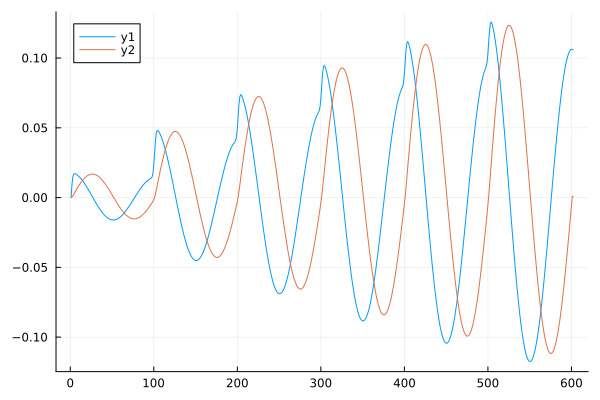

In [14]:
plot(real.(u[1,:]))
plot!(imag.(u[1,:]))

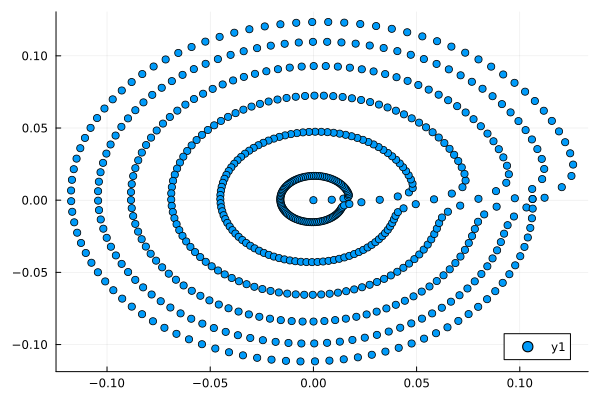

In [15]:
scatter(real.(u[1,:]), imag.(u[1,:]))

In [16]:
p = solution_to_phase(sol, spk_args=spk_args, final_t=false);

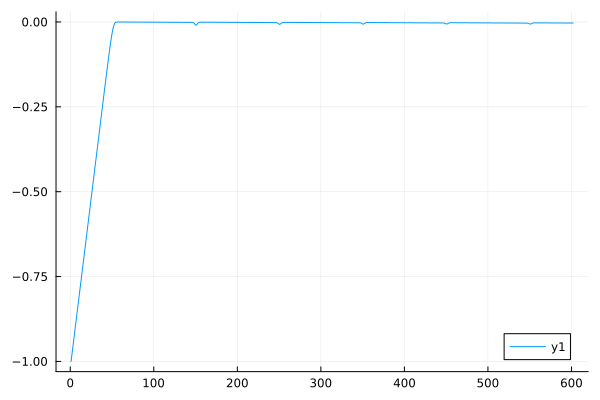

In [17]:
plot(p[51,:])

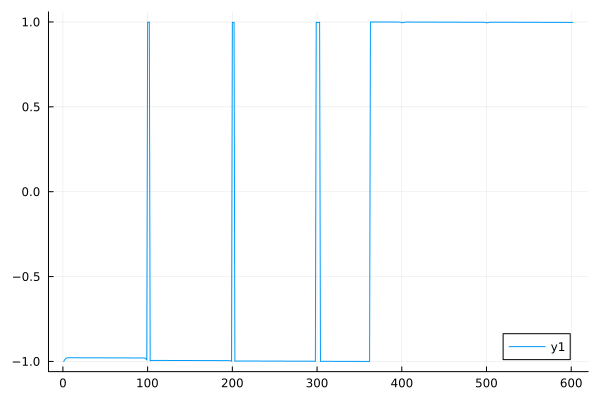

In [18]:
plot(p[1,:])

In [19]:
typeof(u)

Matrix{ComplexF32} (alias for Array{Complex{Float32}, 2})

In [20]:
st1 = solution_to_train(sol, tspan, spk_args = spk_args, offset=0.0)

Spike Train: (101,) with 606 spikes.

In [21]:
p1 = train_to_phase(st1, spk_args=spk_args)

6×101 Matrix{Float64}:
 0.997326  -0.982654  -0.962014  -0.941465  …  0.955291  0.968571  0.997326
 0.996732  -0.983247  -0.962607  -0.942058     0.956919  0.973878  0.996732
 0.996182  -0.983797  -0.963157  -0.942608     0.957058  0.974941  0.996182
 0.995674  -0.984305  -0.963665  -0.943116     0.95688   0.975171  0.995674
 0.995208  -0.984772  -0.964132  -0.943583     0.956602  0.975119  0.995208
 0.997503  -0.982832  -0.963309  -0.943606  …  0.956296  0.974951  0.997503

In [22]:
err2 = p1[end-1,:] .- phases;

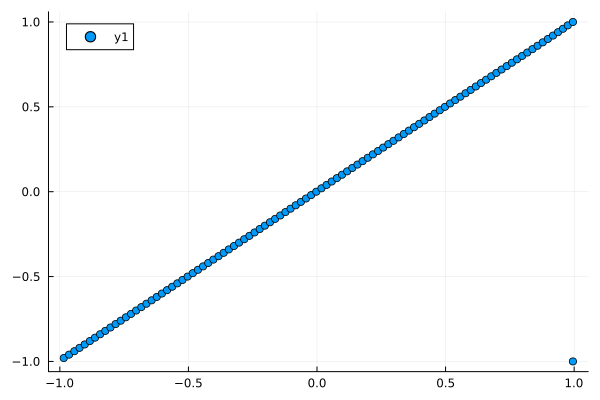

In [23]:
scatter(p1[end-1,:], phases)

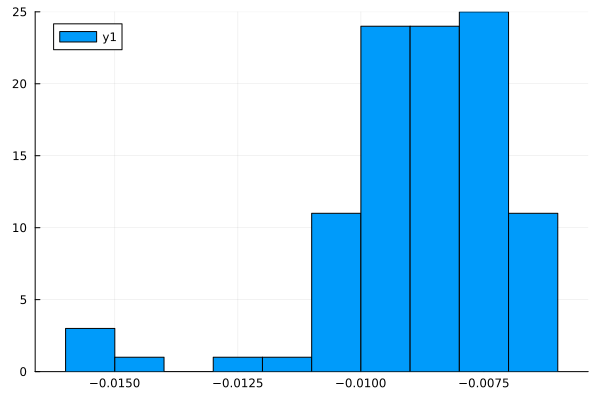

In [24]:
histogram(arc_error(err2))

In [25]:
stg = SpikeTrainGPU(st)

SpikeTrainGPU(CartesianIndex{1}[CartesianIndex(1,), CartesianIndex(2,), CartesianIndex(3,), CartesianIndex(4,), CartesianIndex(5,), CartesianIndex(6,), CartesianIndex(7,), CartesianIndex(8,), CartesianIndex(9,), CartesianIndex(10,)  …  CartesianIndex(92,), CartesianIndex(93,), CartesianIndex(94,), CartesianIndex(95,), CartesianIndex(96,), CartesianIndex(97,), CartesianIndex(98,), CartesianIndex(99,), CartesianIndex(100,), CartesianIndex(101,)], [1, 2, 3, 4, 5, 6, 7, 8, 9, 10  …  597, 598, 599, 600, 601, 602, 603, 604, 605, 606], Float32[0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09  …  5.91, 5.92, 5.93, 5.94, 5.95, 5.96, 5.97, 5.98, 5.99, 5.0], (101,), 101, 0.0f0)

In [26]:
using ChainRulesCore: ignore_derivatives

In [27]:
import .PhasorNetworks: gaussian_kernel

In [28]:
stg.indices

606-element CuArray{CartesianIndex{1}, 1, CUDA.DeviceMemory}:
 CartesianIndex(1,)
 CartesianIndex(2,)
 CartesianIndex(3,)
 CartesianIndex(4,)
 CartesianIndex(5,)
 CartesianIndex(6,)
 CartesianIndex(7,)
 CartesianIndex(8,)
 CartesianIndex(9,)
 CartesianIndex(10,)
 CartesianIndex(11,)
 CartesianIndex(12,)
 CartesianIndex(13,)
 ⋮
 CartesianIndex(90,)
 CartesianIndex(91,)
 CartesianIndex(92,)
 CartesianIndex(93,)
 CartesianIndex(94,)
 CartesianIndex(95,)
 CartesianIndex(96,)
 CartesianIndex(97,)
 CartesianIndex(98,)
 CartesianIndex(99,)
 CartesianIndex(100,)
 CartesianIndex(101,)

In [29]:
stg.linear_indices

606-element CuArray{Int64, 1, CUDA.DeviceMemory}:
   1
   2
   3
   4
   5
   6
   7
   8
   9
  10
  11
  12
  13
   ⋮
 595
 596
 597
 598
 599
 600
 601
 602
 603
 604
 605
 606

In [30]:
stg.shape

(101,)

In [31]:
stg.linear_shape

101

In [32]:
# Set up sample data
n = 1_00
m = 100_000

# Create indices and values on the GPU
d_indices = rand(1:n, m) |> CuArray{Int}
d_values = CUDA.rand(Float32, m);

In [33]:
typeof(m)

Int64

In [34]:
d_indices

100000-element CuArray{Int64, 1, CUDA.DeviceMemory}:
 32
 58
 87
 18
 83
 35
 60
 82
 40
  3
 18
  1
 71
  ⋮
 57
 78
 99
 43
 65
 43
 31
  8
 96
 11
 35
 64

In [35]:
v = parallel_scatter_add(d_indices, d_values, n)

LoadError: UndefVarError: `parallel_scatter_add` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

In [ ]:
for i in 1:1000 parallel_scatter_add(d_indices, d_values, n) end

In [ ]:
for i in 1:10000 parallel_scatter_add(d_indices, d_values, n) end

In [ ]:
#for i in 1:100000 parallel_scatter_add(d_indices, d_values, n) end

In [ ]:
v

100-element CuArray{Float32, 1, CUDA.DeviceMemory}:
 499.93976
 499.83954
 513.1757
 468.01953
 487.15686
 502.0077
 505.1781
 505.55667
 526.85425
 532.7039
 492.40094
 468.17673
 520.70337
   ⋮
 524.37305
 505.12366
 489.31836
 491.29382
 482.91086
 515.16205
 510.70847
 532.45544
 509.3534
 490.6957
 501.73788
 497.59152

In [ ]:
typeof(spk_args.t_window)

Float32

In [ ]:
i0 = gaussian_kernel_gpu.(stg.times, 0.4f0, Float32(spk_args.t_window))

606-element CuArray{Float32, 1, CUDA.DeviceMemory}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

In [ ]:
for i in 1:1000 gaussian_kernel_gpu.(stg.times, 0.4f0, Float32(spk_args.t_window)) end

In [ ]:
for i in 1:10000 gaussian_kernel_gpu.(stg.times, 0.4f0, Float32(spk_args.t_window)) end

In [ ]:
ik = parallel_current(stg, 0.1f0, spk_args)

101-element CuArray{Float32, 1, CUDA.DeviceMemory}:
 1.3887945f-11
 1.6052218f-9
 1.12535176f-7
 4.7851177f-6
 0.00012340969
 0.0019304542
 0.01831562
 0.1053992
 0.36787927
 0.77880085
 1.0
 0.77880085
 0.3678796
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 1.3887945f-11

In [ ]:
iv = stack([parallel_current(stg, t, spk_args) for t in 0.0f0:0.01f0:1.1f0])

101×111 CuArray{Float32, 2, CUDA.DeviceMemory}:
 1.0          0.778801     0.367879     …  0.0          0.0
 0.778801     1.0          0.778801        0.0          0.0
 0.367879     0.778801     1.0             0.0          0.0
 0.105399     0.367879     0.778801        0.0          0.0
 0.0183156    0.105399     0.367879        0.0          0.0
 0.00193045   0.0183156    0.105399     …  0.0          0.0
 0.00012341   0.00193045   0.0183156       0.0          0.0
 4.78512f-6   0.00012341   0.00193045      0.0          0.0
 1.12535f-7   4.78512f-6   0.00012341      0.0          0.0
 1.60522f-9   1.12535f-7   4.7851f-6       0.0          0.0
 1.38879f-11  1.60522f-9   1.12535f-7   …  0.0          0.0
 7.28772f-14  1.38879f-11  1.60522f-9      0.0          0.0
 2.31952f-16  7.28772f-14  1.38879f-11     0.0          0.0
 ⋮                                      ⋱               ⋮
 0.0          0.0          0.0             0.0          0.0
 0.0          0.0          0.0          …  0.0        

In [ ]:
iv2 = Array(iv);

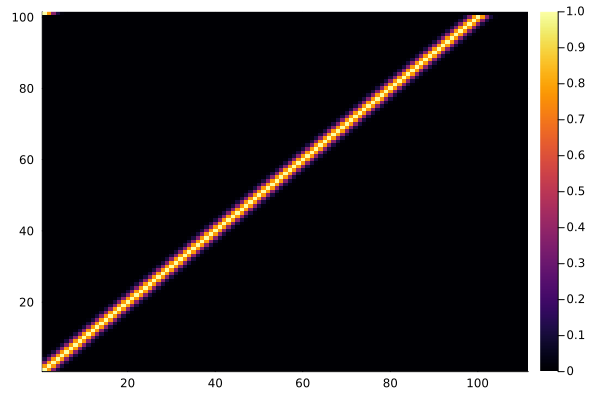

In [ ]:
heatmap(iv2)

In [ ]:
ival = spike_current(stg, 0.4f0, spk_args)

101-element CuArray{Float32, 1, CUDA.DeviceMemory}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

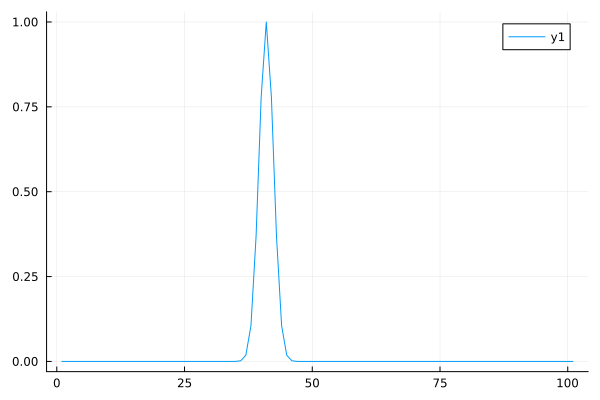

In [ ]:
plot(Array(ival))

In [ ]:
@time ivals = stack([Array(spike_current(stg, t, spk_args)) for t in 0.0f0:0.001f0:1.0f0], dims=1)

  0.173857 seconds (421.53 k allocations: 19.123 MiB, 78.73% compilation time)


1001×101 Matrix{Float32}:
 1.0       0.778801  0.367879  0.105399  …  0.0       0.0       1.0
 0.997503  0.816687  0.405555  0.122151     0.0       0.0       0.997503
 0.99005   0.852144  0.444858  0.140858     0.0       0.0       0.99005
 0.977751  0.884706  0.485537  0.161621     0.0       0.0       0.977751
 0.96079   0.913931  0.527292  0.18452      0.0       0.0       0.96079
 0.939413  0.939413  0.569783  0.209611  …  0.0       0.0       0.939413
 0.913931  0.96079   0.612626  0.236928     0.0       0.0       0.913931
 0.884706  0.977751  0.655406  0.266468     0.0       0.0       0.884706
 0.852144  0.99005   0.697676  0.298197     0.0       0.0       0.852144
 0.816687  0.997503  0.738968  0.33204      0.0       0.0       0.816687
 0.778801  1.0       0.778801  0.367879  …  0.0       0.0       0.778801
 0.738968  0.997503  0.816687  0.405555     0.0       0.0       0.738968
 0.697676  0.99005   0.852144  0.444858     0.0       0.0       0.697676
 ⋮                              

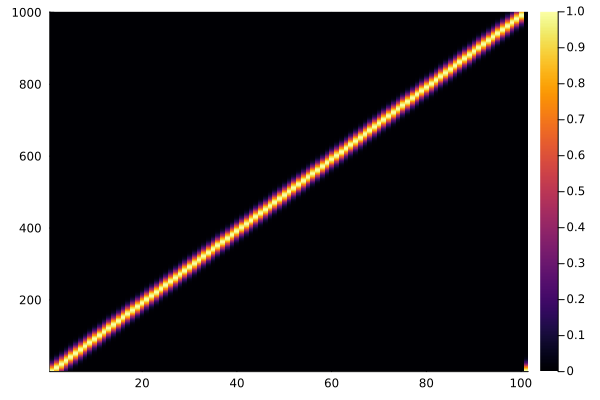

In [ ]:
heatmap(ivals)

In [ ]:
@time ivals2 = stack([Array(spike_current(st, t, spk_args)) for t in 0.0:0.001:1.0], dims=1);

  0.240005 seconds (1.12 M allocations: 55.849 MiB, 99.03% compilation time)


In [ ]:
sum(abs2.(ivals .- ivals2))

31.03234f0

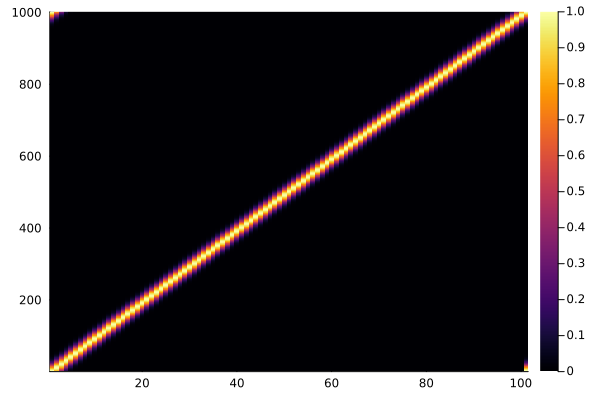

In [ ]:
heatmap(ivals2)

In [ ]:
spk_args

Neuron parameters: Period 1.0 (s)
Current kernel duration: 0.01 (s)
Threshold: 0.001 (V)


In [ ]:
p1 = phase_memory(stg, spk_args=spk_args)

retcode: Success
Interpolation: 3rd order Hermite
t: 1002-element Vector{Float64}:
  0.0
  0.009999999776482582
  0.019999999552965164
  0.029999999329447746
  0.03999999910593033
  0.04999999888241291
  0.05999999865889549
  0.06999999843537807
  0.07999999821186066
  0.08999999798834324
  0.09999999776482582
  0.1099999975413084
  0.11999999731779099
  ⋮
  9.899999778717756
  9.909999778494239
  9.919999778270721
  9.929999778047204
  9.939999777823687
  9.94999977760017
  9.959999777376652
  9.969999777153134
  9.979999776929617
  9.9899997767061
  9.999999776482582
 10.0
u: 1002-element Vector{CuArray{ComplexF32, 1, CUDA.DeviceMemory}}:
 ComplexF32[0.0f0 + 0.0f0im, 0.0f0 + 0.0f0im, 0.0f0 + 0.0f0im, 0.0f0 + 0.0f0im, 0.0f0 + 0.0f0im, 0.0f0 + 0.0f0im, 0.0f0 + 0.0f0im, 0.0f0 + 0.0f0im, 0.0f0 + 0.0f0im, 0.0f0 + 0.0f0im  …  0.0f0 + 0.0f0im, 0.0f0 + 0.0f0im, 0.0f0 + 0.0f0im, 0.0f0 + 0.0f0im, 0.0f0 + 0.0f0im, 0.0f0 + 0.0f0im, 0.0f0 + 0.0f0im, 0.0f0 + 0.0f0im, 0.0f0 + 0.0f0im, 0.0f0 + 0.0f0

In [ ]:
ph1 = solution_to_phase(p1, spk_args=spk_args)

101×1002 CuArray{Float64, 2, CUDA.DeviceMemory}:
 NaN   -0.991252   -0.98433    -0.980325  …  -0.991534  -0.991547  -0.991547
 NaN   -0.988762   -0.980005   -0.973563     -0.981659  -0.981672  -0.981672
 NaN   -0.98642    -0.97568    -0.966434     -0.968345  -0.968358  -0.968358
 NaN   -0.984456   -0.971685   -0.959678     -0.951671  -0.951685  -0.951685
 NaN  NaN          -0.968287   -0.953897     -0.932775  -0.932788  -0.932788
 NaN  NaN         NaN          -0.949385  …  -0.912993  -0.913006  -0.913006
 NaN  NaN         NaN         NaN            -0.893009  -0.893022  -0.893022
 NaN  NaN         NaN         NaN            -0.872998  -0.873011  -0.873011
 NaN  NaN         NaN         NaN            -0.852984  -0.852998  -0.852998
 NaN  NaN         NaN         NaN            -0.832971  -0.832985  -0.832985
 NaN  NaN         NaN         NaN         …  -0.812958  -0.812971  -0.812971
 NaN  NaN         NaN         NaN            -0.792945  -0.792958  -0.792958
 NaN  NaN         NaN      

In [ ]:
ph1c = Array(ph1)

101×1002 Matrix{Float64}:
 NaN   -0.991252   -0.98433    -0.980325  …  -0.991534  -0.991547  -0.991547
 NaN   -0.988762   -0.980005   -0.973563     -0.981659  -0.981672  -0.981672
 NaN   -0.98642    -0.97568    -0.966434     -0.968345  -0.968358  -0.968358
 NaN   -0.984456   -0.971685   -0.959678     -0.951671  -0.951685  -0.951685
 NaN  NaN          -0.968287   -0.953897     -0.932775  -0.932788  -0.932788
 NaN  NaN         NaN          -0.949385  …  -0.912993  -0.913006  -0.913006
 NaN  NaN         NaN         NaN            -0.893009  -0.893022  -0.893022
 NaN  NaN         NaN         NaN            -0.872998  -0.873011  -0.873011
 NaN  NaN         NaN         NaN            -0.852984  -0.852998  -0.852998
 NaN  NaN         NaN         NaN            -0.832971  -0.832985  -0.832985
 NaN  NaN         NaN         NaN         …  -0.812958  -0.812971  -0.812971
 NaN  NaN         NaN         NaN            -0.792945  -0.792958  -0.792958
 NaN  NaN         NaN         NaN            -0.77

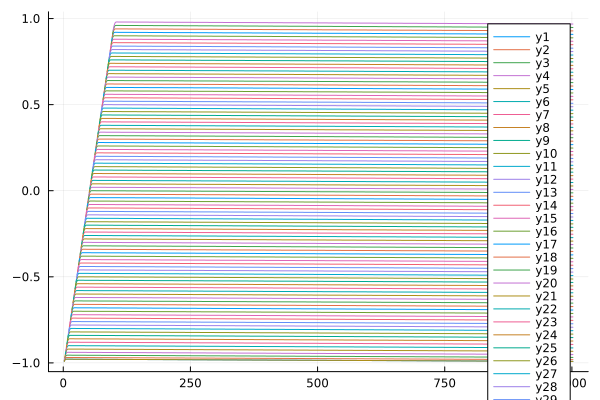

In [ ]:
plot(ph1c')

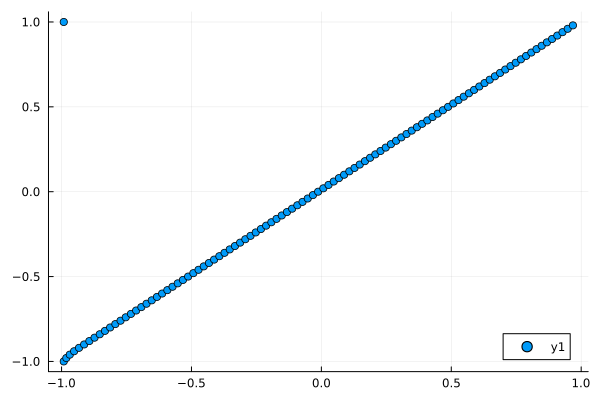

In [ ]:
scatter(ph1c[:,end-1], phases)

In [ ]:
biases = angle_to_complex(range(start=-1.0f0, stop=1.0f0, length=51)) |> cu

51-element CuArray{ComplexF32, 1, CUDA.DeviceMemory}:
        -1.0f0 + 8.742278f-8im
  -0.9921147f0 - 0.1253332f0im
 -0.96858317f0 - 0.2486899f0im
 -0.92977655f0 - 0.3681244f0im
  -0.8763067f0 - 0.48175356f0im
 -0.80901706f0 - 0.5877852f0im
  -0.7289686f0 - 0.68454707f0im
   -0.637424f0 - 0.77051324f0im
  -0.5358269f0 - 0.84432787f0im
 -0.42577937f0 - 0.904827f0im
 -0.30901703f0 - 0.9510565f0im
 -0.18738131f0 - 0.9822872f0im
 -0.06279059f0 - 0.9980267f0im
               ⋮
 -0.18738131f0 + 0.9822872f0im
 -0.30901703f0 + 0.9510565f0im
 -0.42577937f0 + 0.904827f0im
  -0.5358269f0 + 0.84432787f0im
   -0.637424f0 + 0.77051324f0im
  -0.7289686f0 + 0.68454707f0im
 -0.80901706f0 + 0.5877852f0im
  -0.8763067f0 + 0.48175356f0im
 -0.92977655f0 + 0.3681244f0im
 -0.96858317f0 + 0.2486899f0im
  -0.9921147f0 + 0.1253332f0im
        -1.0f0 - 8.742278f-8im

In [ ]:
typeof(biases) <: CuArray{<:Complex}

true

In [ ]:
bias_current(biases, 0.4f0, 0.0f0, spk_args)

51-element CuArray{Float32, 1, CUDA.DeviceMemory}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 3.8f-44
 6.639575f-36
 1.6038108f-28
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

In [ ]:
bivals = stack([bias_current(biases, t, 0.0f0, spk_args) for t in 0.0f0:0.01f0:1.0f0])

51×101 CuArray{Float32, 2, CUDA.DeviceMemory}:
 1.0          0.778801     0.367879     …  0.0          1.0
 0.367879     0.7788       1.0             0.0          0.367879
 0.0183155    0.105399     0.367879        0.0          0.0183155
 0.000123411  0.00193047   0.0183157       0.0          0.000123411
 1.12536f-7   4.78514f-6   0.00012341      0.0          1.12536f-7
 1.38879f-11  1.60523f-9   1.12535f-7   …  0.0          1.38879f-11
 2.31951f-16  7.28768f-14  1.38879f-11     0.0          2.31951f-16
 5.24281f-22  4.4777f-19   2.3195f-16      0.0          5.24281f-22
 1.60381f-28  3.72339f-25  5.24289f-22     0.0          1.60381f-28
 6.63958f-36  4.19009f-32  1.60379f-28     0.0          6.63958f-36
 3.8f-44      6.3816f-40   6.63968f-36  …  0.0          3.8f-44
 0.0          0.0          3.8f-44         0.0          0.0
 0.0          0.0          0.0             0.0          0.0
 ⋮                                      ⋱               ⋮
 0.0          0.0          0.0             0.

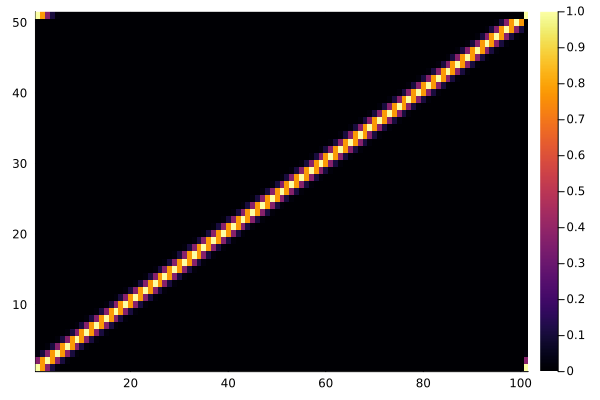

In [ ]:
heatmap(Array(bivals))

In [ ]:
update_fn = spk_args.update_fn

#27 (generic function with 1 method)

In [ ]:
w = CUDA.ones((51,101));

In [ ]:
w * bivals[1,:]

51-element CuArray{Float32, 1, CUDA.DeviceMemory}:
 3.2724535
 3.2724535
 3.2724535
 3.2724535
 3.2724535
 3.2724535
 3.2724535
 3.2724535
 3.2724535
 3.2724535
 3.2724535
 3.2724535
 3.2724535
 ⋮
 3.2724535
 3.2724535
 3.2724535
 3.2724535
 3.2724535
 3.2724535
 3.2724535
 3.2724535
 3.2724535
 3.2724535
 3.2724535
 3.2724535

In [ ]:
du = CUDA.zeros(ComplexF32, (51,))
u = CUDA.zeros(ComplexF32, (51,));

In [ ]:
x = stg

SpikeTrainGPU(CartesianIndex{1}[CartesianIndex(1,), CartesianIndex(2,), CartesianIndex(3,), CartesianIndex(4,), CartesianIndex(5,), CartesianIndex(6,), CartesianIndex(7,), CartesianIndex(8,), CartesianIndex(9,), CartesianIndex(10,)  …  CartesianIndex(92,), CartesianIndex(93,), CartesianIndex(94,), CartesianIndex(95,), CartesianIndex(96,), CartesianIndex(97,), CartesianIndex(98,), CartesianIndex(99,), CartesianIndex(100,), CartesianIndex(101,)], [1, 2, 3, 4, 5, 6, 7, 8, 9, 10  …  597, 598, 599, 600, 601, 602, 603, 604, 605, 606], Float32[0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09  …  5.91, 5.92, 5.93, 5.94, 5.95, 5.96, 5.97, 5.98, 5.99, 5.0], (101,), 101, 0.0f0)

In [ ]:
b = biases;

In [ ]:
function v_bundle_project(x::SpikeTrainGPU, w::CuArray, b::CuArray; tspan::Tuple{<:Real, <:Real}, spk_args::SpikingArgs, return_solution::Bool=false)
    #set up functions to define the neuron's differential equations
    update_fn = spk_args.update_fn
    #get the number of batches & output neurons
    output_shape = (size(w, 1), x.shape[2])
    u0 = CUDA.zeros(ComplexF32, output_shape)

    function dzdt!(du, u, p, t)
        du .= update_fn(u) + w * spike_current(x, t, spk_args) .+ bias_current(b, t, x.offset, spk_args)
        return nothing
    end

    #solve the ODE over the given time span
    prob = ODEProblem(dzdt!, u0, tspan)
    sol = solve(prob, spk_args.solver; spk_args.solver_args...)
    #return full solution
    if return_solution return sol end

    #convert the full solution (potentials) to spikes
    train = solution_to_train(sol, tspan, spk_args = spk_args, offset = x.offset)
    return train
end

v_bundle_project (generic function with 1 method)